In [ ]:
# == source == 
#https://www.kaggle.com/datasets/rahulagrawal1025/stackoverflow-survey-demographic-data?resource=download

In [72]:
# == biliotecas == 

import pandas as pd
import numpy as np
from random import randint
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.cluster import KMeans
tqdm.pandas()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [73]:
# == ler os dados ==

raw = pd.read_csv('dataset/raw.csv')

In [74]:
# == dropar colunas de ResponseId e Unnamed == 

raw.drop(columns={'ResponseId', 'Unnamed: 16', 'Unnamed: 17'}, inplace=True)

In [75]:
# == renomear colunas == 

raw = raw.rename(columns={
    'ResponseId': 'id',
    'Developer': 'status_desenvolvedor',
    'Country': 'pais',
    'Continent': 'continente',
    'Age': 'faixa_idade',
    'RemoteWork': 'modalidade_exercicio',
    'Employment': 'contrato_trabalho',
    'Student': 'sou_estudante',
    'Retired': 'sou_aposentado',
    'Work Looking': 'buscando_trabalho',
    'Freelance': 'sou_freelancer',
    'EdLevel': 'nivel_educacao',
    'Personal Coding Interval': 'anos_experiencia_pessoal',
    'Professional Coding Interval': 'anos_experiencia_profissional',
    ' Salary ': 'salario',
    'Salary Category': 'categoria_salario'
})

In [76]:
# == integridade das colunas ==

raw.isna().sum().to_frame().T

,status_desenvolvedor,pais,continente,faixa_idade,modalidade_exercicio,contrato_trabalho,sou_estudante,sou_aposentado,sou_freelancer,buscando_trabalho,nivel_educacao,anos_experiencia_pessoal,anos_experiencia_profissional,salario,categoria_salario
0,0,1211,1211,449,15374,0,0,0,0,0,1211,0,0,0,41165


In [77]:
# == dropar linhas onde [pais, continente, nivel_educacao, faixa_idade, modalidade_trabalho] é nan ==

raw = raw.dropna(subset=['pais', 'continente', 'nivel_educacao', 'faixa_idade', 'modalidade_exercicio'])

In [78]:
# == integridade das colunas ==

raw.isna().sum().to_frame().T

,status_desenvolvedor,pais,continente,faixa_idade,modalidade_exercicio,contrato_trabalho,sou_estudante,sou_aposentado,sou_freelancer,buscando_trabalho,nivel_educacao,anos_experiencia_pessoal,anos_experiencia_profissional,salario,categoria_salario
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25763


In [79]:
# == ver as colunas faltantes sobre modalidade_trabalho ==

for col in raw.columns:
    raw[col].value_counts().to_frame().T

,Full Time,Part Time,Veteran,Hobby,Learning
status_desenvolvedor,63537,6554,1363,1127,1098


,USA,Germany,UK,India,Canada,France,Netherlands,Poland,Brazil,Australia,...,Palau,Guyana,Monaco,Laos,North Korea,Brunei Darussalam,Liechtenstein,Timor-Leste,Samoa,San Marino
pais,16058,6230,4773,4141,2977,2525,2042,2038,1805,1764,...,3,3,2,2,2,2,1,1,1,1


,Europe,North America,Asia,South America,Oceania,Africa,Nomadic
continente,34200,19918,12014,3385,2363,1758,41


,Adults,Youth,Seniors,Baby
faixa_idade,58504,10853,3728,594


,Hybrid,Remote,In-person
modalidade_exercicio,31087,30502,12090


,Full-time,Unemployed,Part-time
contrato_trabalho,50723,18184,4772


,NO,YES
sou_estudante,61660,12019


,NO,YES
sou_aposentado,73073,606


,No,Yes
sou_freelancer,59747,13932


,NO,YES
buscando_trabalho,72910,769


,Bachelor,Masters,Self-Study,High School,Professional,Associate,Something else,School
nivel_educacao,33180,19326,9296,4361,3594,2405,942,575


,5-8,9-12,13-16,17-20,1-4,25-28,21-24,29-32,33-36,37-40,41-44,45-48,0,49-52
anos_experiencia_pessoal,15566,14370,10648,7831,7109,4653,4142,3000,2131,2094,918,526,367,324


,1-4,5-8,9-12,0,13-16,17-20,21-24,25-28,29-32,33-36,37-40,41-44,45-48,49-52
anos_experiencia_profissional,17109,15343,11105,8217,6982,5184,3186,2793,1565,1050,673,235,142,95


,NA,"64,254","53,545","150,000","74,963","200,000","85,672","120,000","107,090","42,836",...,"195,800","262,604","216,822","6,167","107,946","44,322","701,382","16,794","398,000","16,917"
salario,25763,781,615,585,556,556,532,483,463,420,...,1,1,1,1,1,1,1,1,1,1


,Mid,High,Very High,Low,Very Low
categoria_salario,22537,18703,3250,2745,681


In [80]:
# == tratar coluna de salário ==

raw.salario = raw.salario.astype(str)
raw.salario = raw.salario.str.replace(',', '')
raw.salario = raw.salario.str.replace('NA', '0')
raw.salario = raw.salario.astype(int)

In [81]:
# == dropar colunas de intervalo de anos_experiencia == 

raw.loc[raw.anos_experiencia_pessoal == '0', 'anos_experiencia_pessoal'] = '0-0'
raw.loc[raw.anos_experiencia_profissional == '0', 'anos_experiencia_profissional'] = '0-0'

In [82]:
# == tratar colunas de anos_experiencia == 

raw['intervalo_min_anos_exp_pessoal'] = raw.anos_experiencia_pessoal.str.split('-').str[0].astype(int)
raw['intervalo_max_anos_exp_pessoal'] = raw.anos_experiencia_pessoal.str.split('-').str[1].astype(int)
raw['intervalo_min_anos_exp_profissional'] = raw.anos_experiencia_profissional.str.split('-').str[0].astype(int)
raw['intervalo_max_anos_exp_profissional'] = raw.anos_experiencia_profissional.str.split('-').str[1].astype(int)

In [83]:
# == dropar colunas de intervalo de anos_experiencia == 

raw.drop(columns={'anos_experiencia_pessoal', 'anos_experiencia_profissional'}, inplace=True)

In [84]:
# == tratar colunas binárias == 

cols = ['sou_estudante', 'sou_aposentado', 'sou_freelancer', 'buscando_trabalho']

for col in cols:
    raw[col] = raw[col].apply(
        lambda x:
        'Nao' if x in ['NO', 'No'] else 'Sim'
    )

In [85]:
# == remover linhas sem salário ==

raw = raw[raw.salario != 0]

In [86]:
raw.categoria_salario.value_counts()

Mid          22537
High         18703
Very High     3250
Low           2745
Very Low       681
Name: categoria_salario, dtype: int64

In [87]:
# == reformular a coluna de categoria de salário mais balanceada ==

raw.categoria_salario.value_counts()
# raw.categoria_salario = raw.salario.progress_apply(
#     lambda x: 
#     'Very Low' if x <= raw.salario.quantile(0.2) else
#     'Low' if x > raw.salario.quantile(0.2) and x <= raw.salario.quantile(0.4) else
#     'Mid' if x > raw.salario.quantile(0.4) and x <= raw.salario.quantile(0.6) else
#     'High' if x > raw.salario.quantile(0.6) and x <= raw.salario.quantile(0.8) else
#     'Very High'
# )
raw.categoria_salario = raw.salario.progress_apply(
    lambda x: 
    'Low' if x <= raw.salario.quantile(0.25) else
    'Mid' if x > raw.salario.quantile(0.25) and x <= raw.salario.quantile(0.5) else
    'High' if x > raw.salario.quantile(0.5) and x <= raw.salario.quantile(0.75) else
    'Very High'
)

Mid          22537
High         18703
Very High     3250
Low           2745
Very Low       681
Name: categoria_salario, dtype: int64

100%|██████████| 47916/47916 [02:53<00:00, 275.40it/s]


In [88]:
# == drop da coluna de salário == 

raw = raw.drop(columns={'salario'})

In [89]:
# == arrumar a faixa_idade igual a 'Baby' ==

raw.loc[raw.faixa_idade == 'Baby', 'faixa_idade'] = 'Youth'

In [90]:
# == criar uma coluna de intervalo de idade min e max == 

raw['idade'] = raw.intervalo_min_anos_exp_pessoal.progress_apply(
    lambda x:
    x + randint(16, 30)
)

100%|██████████| 47916/47916 [00:00<00:00, 423789.82it/s]


In [91]:
# == feature de ano atual na empresa == 

raw['anos_atividade_atual'] = raw.intervalo_min_anos_exp_profissional.apply(
    lambda x:
    randint(1, x) if x != 0 else 0
)

In [92]:
# == reorganizar o dataset == 

raw = raw[[
    'pais', 'continente', 'idade', 
    'faixa_idade', 'modalidade_exercicio', 'contrato_trabalho', 
    'sou_estudante', 'sou_aposentado', 'sou_freelancer', 
    'buscando_trabalho', 'nivel_educacao', 'intervalo_min_anos_exp_pessoal',
    'intervalo_max_anos_exp_pessoal', 'intervalo_min_anos_exp_profissional',
    'intervalo_max_anos_exp_profissional', 'anos_atividade_atual', 'categoria_salario'
]]

In [101]:
# == inserir de forma randômica dados nulos nas células == 

for n in range(100):
    raw.iloc[randint(0, raw.shape[0]-1), randint(1, len(raw.columns) - 2)] = np.nan

In [103]:
# == salvar o estado atual do dataset == 

raw.to_parquet('dataset/final_case.parquet')

In [24]:
# == aplicar transformações para gerar o rótulo final do classificador ==

transform = raw.copy()

In [25]:
# == selecionar os nomes das colunas de dtypes == 

object_cols = transform.select_dtypes(include=['object']).columns[:-1]
label_col = 'categoria_salario'
numeric_cols = transform.select_dtypes(exclude=['object']).columns

In [27]:
# == aplicar one hot enconding das colunas ==

encoded = pd.get_dummies(transform[object_cols], columns=object_cols)

In [28]:
# == juntar os dataframes ==

transform_final = transform[numeric_cols].join(encoded).join(transform[[label_col]])

In [29]:
# == mapear a label ==

# labels_map = {
#     'Very Low': 0,
#     'Low': 1,
#     'Mid': 2,
#     'High': 3,
#     'Very High': 4
# }
labels_map = {
    'Low': 0,
    'Mid': 1,
    'High': 2,
    'Very High': 3
}
transform_final.categoria_salario = transform_final.categoria_salario.map(labels_map)

In [30]:
# == aplicar k-menas == 

kmeans = KMeans(n_clusters=5, random_state=42)
transform_final['cluster'] = kmeans.fit_predict(transform_final)

In [31]:
# == analisar o cluster em relação à categoria de salário ==

analise_cluster = transform_final[['cluster', 'categoria_salario']]
analise_cluster = analise_cluster.value_counts()\
                                 .to_frame()\
                                 .reset_index()
analise_cluster = analise_cluster.sort_values(by=['categoria_salario', 'cluster'])
analise_cluster = analise_cluster.rename(columns={0: 'contagem'})
analise_cluster['porcentagem'] = analise_cluster.apply(
    lambda x:
    x.contagem / analise_cluster[analise_cluster.categoria_salario == x.categoria_salario].contagem.sum(),
    axis=1
)
analise_cluster

,cluster,categoria_salario,contagem,porcentagem
5,0,0,3274,0.272993
19,1,0,276,0.023013
0,2,0,6452,0.537980
13,3,0,1356,0.113066
17,4,0,635,0.052948
1,0,1,4194,0.342507
18,1,1,525,0.042875
2,2,1,3781,0.308779
10,3,1,2444,0.199592
15,4,1,1301,0.106247


In [32]:
# == separar os dados X e y == 

X = transform_final.drop(columns={'categoria_salario', 'cluster'})
y = transform_final.categoria_salario

In [33]:
# == train test split == 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [95]:
# == treinar o modelo == 

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[16:36:43] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [16:36:43] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/eidi/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7ff90d88f459]
  [bt] (1) /home/eidi/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7ff90d890571]
  [bt] (2) /home/eidi/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7ff90d89095a]
  [bt] (3) /home/eidi/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7ff90d8d0a3d]
  [bt] (4) /home/eidi/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7ff90d76a098]
  [bt] (5) /home/eidi/anaconda3/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7ff98590bec0]
  [bt] (6) /home/eidi/anaconda3/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7ff98590b87d]
  [bt] (7) /home/eidi/anaconda3/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7ff985b211de]
  [bt] (8) /home/eidi/anaconda3/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x12c14) [0x7ff985b21c14]



<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix')

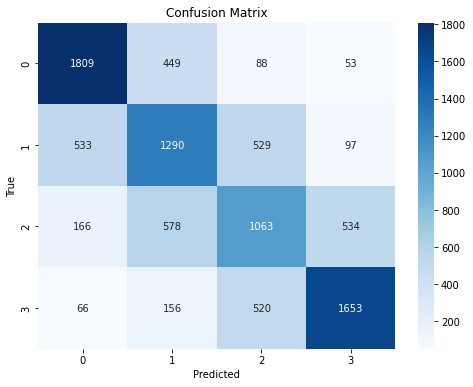

In [36]:
# == plotar matriz de confusão == 

res = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(res, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [299]:
# == definição do espaço de parâmetros ==

param_dist = {
    'n_estimators': [randint(100, 500)],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [randint(2, 10)],
    'min_child_weight': [randint(1, 10)],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

In [300]:
# == rodar random search == 

model = XGBClassifier()
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    random_state=42,
    verbose=3
)
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.3, max_depth=10, min_child_weight=4, n_estimators=134, subsample=0.8;, score=0.501 total time=  18.6s
[CV 2/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.3, max_depth=10, min_child_weight=4, n_estimators=134, subsample=0.8;, score=0.513 total time=  18.1s
[CV 3/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.3, max_depth=10, min_child_weight=4, n_estimators=134, subsample=0.8;, score=0.511 total time=  18.8s
[CV 4/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.3, max_depth=10, min_child_weight=4, n_estimators=134, subsample=0.8;, score=0.517 total time=  18.6s
[CV 5/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.3, max_depth=10, min_child_weight=4, n_estimators=134, subsample=0.8;, score=0.502 total time=  18.7s
[CV 1/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.1, max_depth=10, min_child_weight=4, n_estimators=134, su

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix')

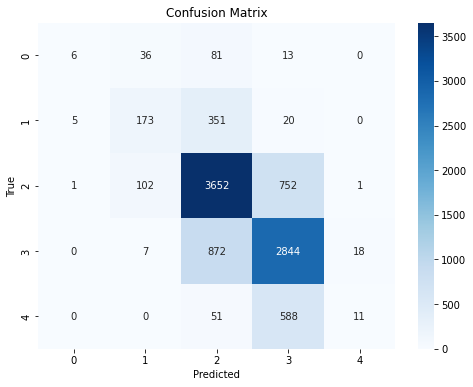

In [256]:
# == plotar matriz de confusão == 

res = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(res, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()